# (10주차) 5월4일

- toc:true
- branch: master
- badges: true
- comments: true
- author: 최규빈

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.experimental.numpy as tnp

In [2]:
tf.config.experimental.list_physical_devices()

2022-05-06 10:37:51.868820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+ s + ';}')

### 로지스틱 모형 (1): 활성화함수로 sigmoid 선택

`-` 기본버전은 아래와 같다 

$$y_i \approx \text{sigmoid}(b + w_1 x_{1,i} + \dots + w_{784}x_{784,i})= \frac{\exp(b + w_1 x_{1,i} + \dots + w_{784}x_{784,i})}{1+\exp(b + w_1 x_{1,i} + \dots + w_{784}x_{784,i})}$$

`-` 벡터버전은 아래와 같다. 

$${\boldsymbol y} \approx \text{sigmoid}({\bf X}{\bf W} + b) = \frac{\exp({\bf XW} +b)}{1+\exp({\bf XW} +b)}$$ 

`-` 벡터버전에 익숙해지도록 하자. 벡터버전에 사용된 차원 및 연산을 정리하면 아래와 같다. 

- ${\bf X}$: (n,784) matrix 

- ${\boldsymbol y}$: (n,1) matrix

- ${\bf W}$: (784,1) matrix

- $b$: (1,1) matrix

- `+`, `exp` 는 브로드캐스팅

### 로지스틱 모형 (2): 활성화함수로 softmax 선택

`-` $y_i=0 \text{ or } 1$ 대신에 $\boldsymbol{y}_i=[y_{i1},y_{i2}]= [1,0] \text { or } [0,1]$와 같이 코딩하면 어떠할까? (즉 원핫인코딩을 한다면?) 

`-` 활성화 함수를 취하기 전의 버전은 아래와 같이 볼 수 있다. 

$$[{\boldsymbol y}_1 ~ {\boldsymbol y}_2] \propto  [ {\bf X}{\bf W}_1  ~ {\bf X}{\bf W}_2] + [b_1 ~ b_2]= {\bf X} [{\bf W}_1 {\bf W}_2] + [b_1 ~ b_2]= {\bf X}{\bf W} + {\boldsymbol b}$$
    
여기에서 매트릭스 및 연산의 차원을 정리하면 아래와 같다. 

- ${\bf X}$: (n,784) matrix 

- ${\boldsymbol y}_1,{\boldsymbol y}_2$: (n,1) matrix

- ${\boldsymbol y}:=[{\boldsymbol y}_1~ {\boldsymbol y}_2]$: (n,2) matrix

- ${\bf W}_1$, ${\bf W}_2$: (784,1) matrix

- ${\bf W}:=[{\bf W}_1~ {\bf W}_2]$: (784,2) matrix

- $b_1,b_2$: (1,1) matrix

- $\boldsymbol{b}:= [b_1 ~b_2] $: (1,2) matrix

- `+` 는 브로드캐스팅



`-` 즉 로지스틱 모형 (1)의 형태를 겹쳐놓은 형태로 해석할 수 있음. 따라서 ${\bf X} {\bf W}_1 + b_1$와 ${\bf X} {\bf W}_2 + b_2$의 row값이 클수록 ${\boldsymbol y}_1$와 ${\boldsymbol y}_2$의 row값이 1이어야 함 

- ${\boldsymbol y}_1 \propto  {\bf X} {\bf W}_1 + b_1$ $\to$ ${\bf X} {\bf W}_1 + b_1$의 row값이 클수록 $\boldsymbol{y}_1$의 row 값이 1이라면 모형계수를 잘 추정한것 
- ${\boldsymbol y}_2 \propto  {\bf X} {\bf W}_2 + b_2$ $\to$ ${\bf X} {\bf W}_2 + b_2$의 row값이 클수록 $\boldsymbol{y}_2$의 row 값을 1이라면 모형계수를 잘 추정한것


`-` (문제) ${\bf X}{\bf W}_1 +b_1$의 값이 500, ${\bf X}{\bf W}_2 +b_2$의 값이 200 인 row가 있다고 하자. 대응하는 $\boldsymbol{y}_1, \boldsymbol{y}_2$의 row값은 얼마로 적합되어야 하는가? 

(1) $[0,0]$

(2) $[0,1]$

(3) $[1,0]$ <-- 이게 답이다!

(4) $[1,1]$

> note: 둘다 0 혹은 둘다 1로 적합할수는 없으니까 (1), (4)는 제외한다. ${\bf X}{\bf W}_1 +b_1$의 값이 ${\bf X}{\bf W}_2 +b_2$의 값보다 크므로 (3)번이 합리적임 

`-` **목표:** 위와 같은 문제의 답을 유도해주는 활성화함수를 설계하자. 즉 합리적인 $\hat{\boldsymbol{y}}_1,\hat{\boldsymbol{y}}_2$를 구해주는 활성화 함수를 설계해보자. 이를 위해서는 아래의 사항들이 충족되어야 한다. 

(1) $\hat{\boldsymbol{y}}_1+\hat{\boldsymbol{y}}_2={\bf 1}$ 이어야 한다. (확률의 총합은 1이니까!)

(2) $\hat{\boldsymbol{y}}_1$와 $\hat{\boldsymbol{y}}_2$를 각각 따로해석하면 로지스틱처럼 되면 좋겠다. 

`-` 아래와 같은 활성화 함수를 도입하면 어떨까? 

$[\hat{{\boldsymbol y}}_1 ~ \hat{{\boldsymbol y}}_2] = \big[ \frac{\exp({\bf X}\hat{{\bf W}}_1+\hat{b}_1)}{\exp({\bf X}\hat{{\bf W}}_1+\hat{b}_1)+\exp({\bf X}\hat{{\bf W}}_2+\hat{b}_2)}  ~~ \frac{\exp({\bf X}\hat{{\bf W}}_2+\hat{b}_2)}{\exp({\bf X}\hat{{\bf W}}_1+\hat{b}_1)+\exp({\bf X}\hat{{\bf W}}_2+\hat{b}_2)}  \big] $ 

${\boldsymbol y} \approx \text{softmax}({\bf X}{\bf W} + {\boldsymbol b})$ 

### 모형의 비교

`-` 수식장난 
$$\frac{\exp(\beta_0+\beta_1 x_i)}{1+\exp(\beta_0+\beta_1x_i)}=\frac{\exp(\beta_0+\beta_1 x_i)}{e^0+exp(\beta_0+\beta_1x_i)}$$

`-` 통찰 
- 모형2: ${\bf X}{\bf W}_1 +b_1$ 와 ${\bf X}{\bf W}_2 +b_2$ 의 크기를 비교하고 확률 결정
- 모형1: ${\bf X}{\bf W} +b$와 $0$의 크기를 비교하고 확률 결정 (${\bf X}{\bf W} +b$의 row값이 양수이면 1로 예측하고 음수이면 0으로 예측 

`-` 파라메터의 수 

`-` 표현력

- note: $\big(\frac{e^{300}}{e^{300}+e^{500}},\frac{e^{500}}{e^{300}+e^{500}}\big) =\big( \frac{e^{0}}{e^{0}+e^{200}}, \frac{e^{200}}{e^{0}+e^{200}}\big)$

`-` 확장성 

### 분류할 클래스가 3개 이상일 경우 신경망 모형의 설계 

`-` y의 모양: [0 1 0 0 0 ] 

`-` 활성화함수의 선택: softmax 

`-` 손실함수의 선택: cross entropy

### Fashion_MNIST 다중분류 

`-` 시도1

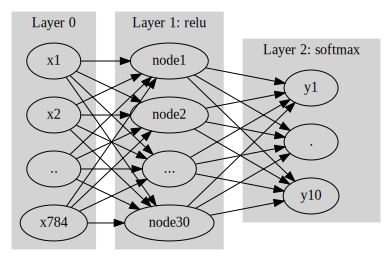

In [9]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;

    "node1" -> "y10"
    "node2" -> "y10"
    "..." -> "y10"
    "node30" -> "y10"
    
    "node1" -> "y1"
    "node2" -> "y1"
    "..." -> "y1"
    "node30" -> "y1"
    
    "node1" -> "."
    "node2" -> "."
    "..." -> "."
    "node30" -> "."
    
    label = "Layer 2: softmax"
}
''')

In [10]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [13]:
tf.keras.utils.to_categorical(y_train)

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
X=x_train.reshape(-1,784)
y=tf.keras.utils.to_categorical(y_train)
XX=x_test.reshape(-1,784)
yy=tf.keras.utils.to_categorical(y_test)

In [17]:
tf.random.set_seed(43052)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(10,activation='softmax'))
net.compile(optimizer='adam',loss=tf.losses.categorical_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=20,batch_size=1200)

Epoch 1/20
50/50 [==============================] - 0s 1ms/step - loss: 32.5672 - accuracy: 0.3730
Epoch 2/20
50/50 [==============================] - 0s 1ms/step - loss: 2.4414 - accuracy: 0.3877
Epoch 3/20
50/50 [==============================] - 0s 1ms/step - loss: 1.9154 - accuracy: 0.3809
Epoch 4/20
50/50 [==============================] - 0s 910us/step - loss: 1.7740 - accuracy: 0.4041
Epoch 5/20
50/50 [==============================] - 0s 979us/step - loss: 1.6474 - accuracy: 0.4517
Epoch 6/20
50/50 [==============================] - 0s 1ms/step - loss: 1.5429 - accuracy: 0.4842
Epoch 7/20
50/50 [==============================] - 0s 1ms/step - loss: 1.4649 - accuracy: 0.4992
Epoch 8/20
50/50 [==============================] - 0s 1ms/step - loss: 1.4001 - accuracy: 0.5227
Epoch 9/20
50/50 [==============================] - 0s 1ms/step - loss: 1.3400 - accuracy: 0.5461
Epoch 10/20
50/50 [==============================] - 0s 968us/step - loss: 1.2882 - accuracy: 0.5539
Epoch 11/20


In [18]:
net.evaluate(XX,yy)

313/313 [==============================] - 0s 923us/step - loss: 1.0963 - accuracy: 0.5930


[1.096295952796936, 0.5929999947547913]

`-` 시도2

In [19]:
tf.random.set_seed(43052)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(500,activation='relu'))
net.add(tf.keras.layers.Dense(500,activation='relu'))
net.add(tf.keras.layers.Dense(10,activation='softmax'))
net.compile(optimizer='adam',loss=tf.losses.categorical_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=50,batch_size=1200)

Epoch 1/50
50/50 [==============================] - 0s 1ms/step - loss: 21.6114 - accuracy: 0.6873
Epoch 2/50
50/50 [==============================] - 0s 1ms/step - loss: 1.9367 - accuracy: 0.8036
Epoch 3/50
50/50 [==============================] - 0s 1ms/step - loss: 1.2290 - accuracy: 0.8208
Epoch 4/50
50/50 [==============================] - 0s 1ms/step - loss: 0.9411 - accuracy: 0.8331
Epoch 5/50
50/50 [==============================] - 0s 1ms/step - loss: 0.7520 - accuracy: 0.8440
Epoch 6/50
50/50 [==============================] - 0s 1ms/step - loss: 0.6388 - accuracy: 0.8528
Epoch 7/50
50/50 [==============================] - 0s 1ms/step - loss: 0.5701 - accuracy: 0.8581
Epoch 8/50
50/50 [==============================] - 0s 1ms/step - loss: 0.4967 - accuracy: 0.8686
Epoch 9/50
50/50 [==============================] - 0s 1ms/step - loss: 0.4451 - accuracy: 0.8732
Epoch 10/50
50/50 [==============================] - 0s 1ms/step - loss: 0.3988 - accuracy: 0.8839
Epoch 11/50
50/50 

In [20]:
net.evaluate(XX,yy)

313/313 [==============================] - 0s 942us/step - loss: 0.7289 - accuracy: 0.8618


[0.7289316654205322, 0.8618000149726868]

`-` 시도3

`-` 시도1,2,3 비교